In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt


                 Sales
Date                  
2015-01-01  117.632295
2015-01-02  193.084859
2015-01-03  148.211661
2015-01-04  152.146904
2015-01-05  173.239551


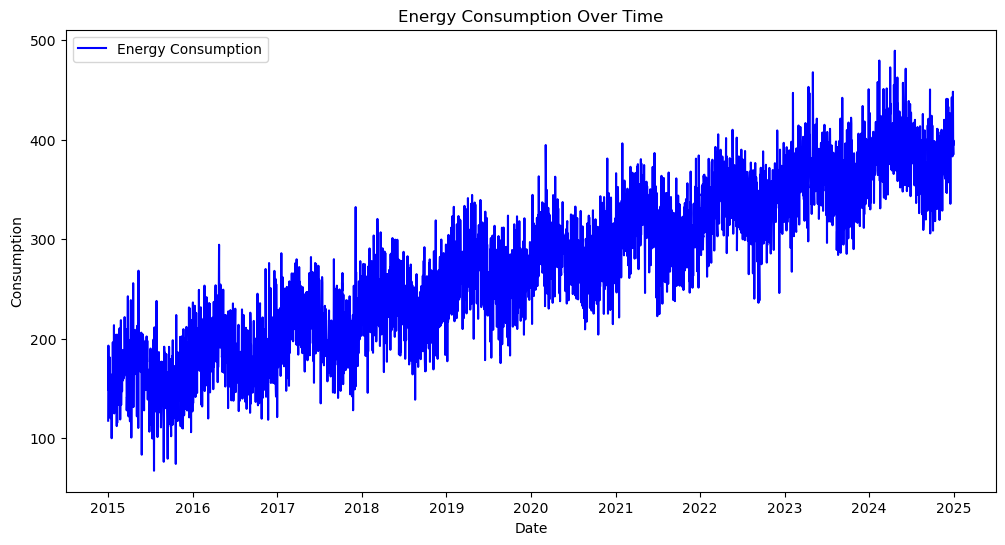

In [2]:
file_path = "time_series_sales.csv"  
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
print(df.head())
plt.figure(figsize=(12,6))
plt.plot(df, label="Energy Consumption", color='blue')
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("Energy Consumption Over Time")
plt.legend()
plt.show()


In [3]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")


Train size: 2922, Test size: 731


In [6]:
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
arima_model = ARIMA(train, order=(5,1,2), freq='D')  # Explicitly set freq='D'
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=len(test))
rmse_arima = sqrt(mean_squared_error(test, arima_pred))
print(f"RMSE - ARIMA: {rmse_arima:.2f}")


RMSE - ARIMA: 43.02


In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df)
def create_dataset(data, time_step=50):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)
time_step = 50
X, Y = create_dataset(df_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")


X_train shape: (2881, 50, 1), X_test shape: (721, 50, 1)
Y_train shape: (2881,), Y_test shape: (721,)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
91/91 [==============================] - 18s 145ms/step - loss: 0.0149
Epoch 2/20
91/91 [==============================] - 12s 136ms/step - loss: 0.0057
Epoch 3/20
91/91 [==============================] - 12s 136ms/step - loss: 0.0054
Epoch 4/20
91/91 [==============================] - 12s 133ms/step - loss: 0.0056
Epoch 5/20
91/91 [==============================] - 12s 130ms/step - loss: 0.0055
Epoch 6/20
91/91 [==============================] - 12s 130ms/step - loss: 0.0054
Epoch 7/20
91/91 [==============================] - 12s 132ms/step - loss: 0.0054
Epoch 8/20
91/91 [==============================] - 12s 133ms/step - loss: 0.0054
Epoch 9/20
91/91 [==============================] - 12s 134ms/step - loss: 0.0055
Epoch 10/20
91/91 [==============================] - 12s 134ms/step - loss: 0.0056
Epoch 11/20
91/91 [==============================] - 12s 134ms/step - loss: 0.0056
Epoch 12/20
91/91 [==============================] - 13s 138ms/step - loss: 0.0056
Epoch 13/20
9

23/23 [==============================] - 1s 48ms/step
RMSE - LSTM: 40.22


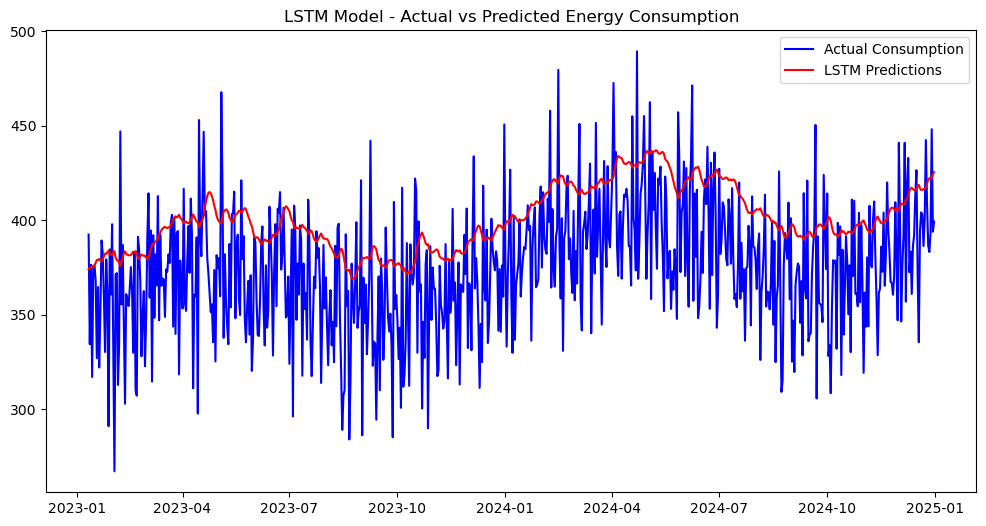

In [9]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1,1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1,1))
rmse_lstm = sqrt(mean_squared_error(Y_test, test_predict))
print(f"RMSE - LSTM: {rmse_lstm:.2f}")
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(Y_test):], Y_test, label="Actual Consumption", color='blue')
plt.plot(df.index[-len(Y_test):], test_predict, label="LSTM Predictions", color='red')
plt.legend()
plt.title("LSTM Model - Actual vs Predicted Energy Consumption")
plt.show()


In [10]:
print(f"RMSE - ARIMA: {rmse_arima:.2f}")
print(f"RMSE - LSTM: {rmse_lstm:.2f}")
if rmse_arima < rmse_lstm:
    print("ARIMA performed better.")
else:
    print("LSTM performed better.")


RMSE - ARIMA: 43.02
RMSE - LSTM: 40.22
LSTM performed better.
